In [ ]:
import sys
import os
sys.path.append(os.path.expanduser('~/myPy/VEBTF'))
sys.path.append(os.path.expanduser('~/myPy/VEBTF/src'))
sys.path.append(os.path.expanduser('~/myPy/VEBTF/VEBTF-paper'))
from matplotlib import pyplot as plt
from src.vebtf import VEBTF
import seaborn as sns
import numpy as np
from skimage.restoration import denoise_wavelet, estimate_sigma
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from methods.methods import *
import matplotlib.pyplot as plt
import yfinance as yf
import timeit

In [12]:
import pandas as pd
df = pd.read_csv(os.path.expanduser("~/myPy/VEBTF/VEBTF-paper/realdata/dataset/all_six_datasets/illness/national_illness.csv"))
df.head()

,date,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,2002-01-01 00:00:00,1.22262,1.16668,582,805,2060,754,176569
1,2002-01-08 00:00:00,1.33344,1.21650,683,872,2267,785,186355
2,2002-01-15 00:00:00,1.31929,1.13057,642,878,2176,831,192469
3,2002-01-22 00:00:00,1.49484,1.25246,728,1045,2599,863,207512
4,2002-01-29 00:00:00,1.47195,1.30237,823,1189,2907,909,223208


In [13]:
df.shape

(966, 8)

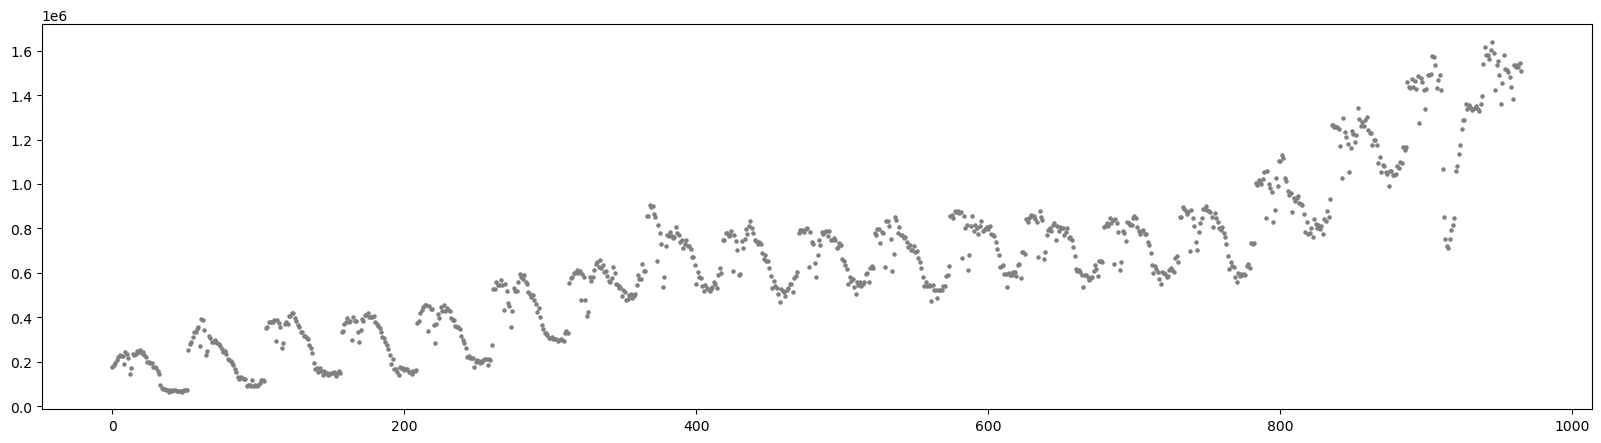

In [14]:
y = df['OT'].values
y = y.squeeze()
y = np.array(y,dtype=float)
n = len(y)
plt.figure(figsize=(20, 5))
plt.scatter(np.arange(n),y,color='grey',s=5)
plt.show()

In [8]:
susie20 = susie_tf(L=20)
susie20.fit(y)

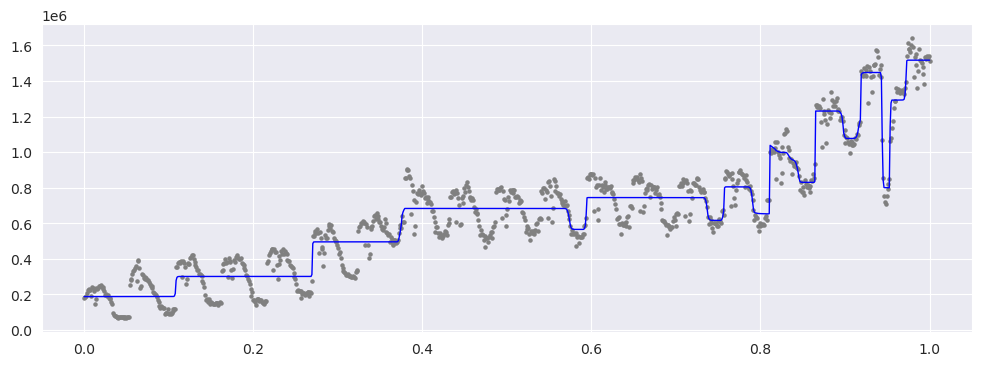

In [13]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
#plt.plot(np.linspace(0,1,len(y)),model.mu, color='black')
plt.plot(np.linspace(0,1,len(y)),susie20.mu, color='blue',linewidth = 1)
#plt.plot(np.linspace(0,1,len(y)),wave.mu, color='red')
plt.show()

In [34]:
susie500 = susie_tf(L=500)
susie500.fit(y)

In [20]:
# # save susie100 as pickle
import pickle
# with open('results/susie500_illness.pkl', 'wb') as f:
#     pickle.dump(susie500, f)

with open('results/susie500_illness.pkl', 'rb') as f:
    susie500 = pickle.load(f)

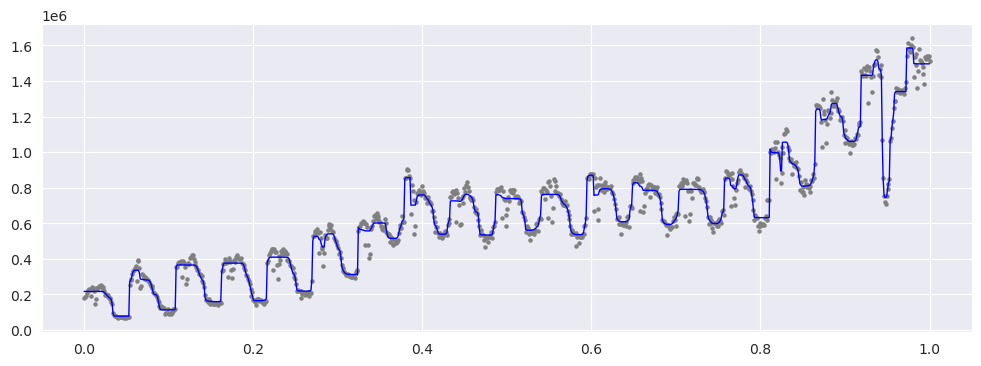

In [21]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
plt.plot(np.linspace(0,1,len(y)),susie500.mu, color='blue',linewidth = 1)
plt.show()

In [23]:
n = len(y)
genlasso = genlasso_tf(ord=0)
genlasso.fit(y)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


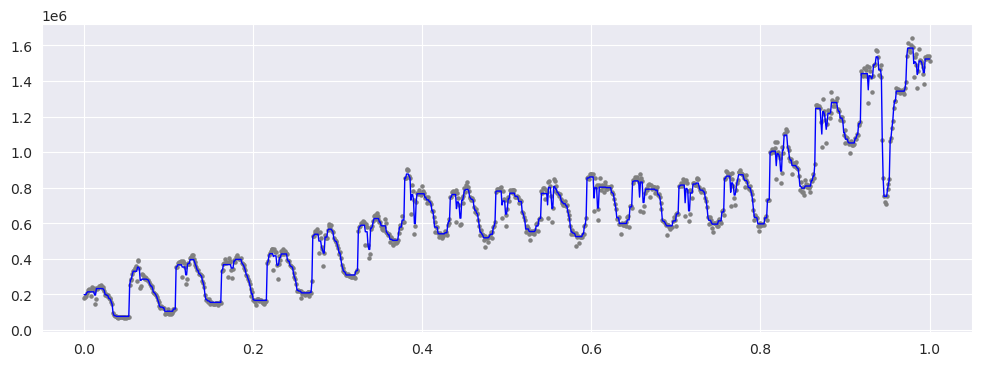

In [24]:
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
#plt.plot(np.linspace(0,1,len(y)),model.mu, color='black')
plt.plot(np.linspace(0,1,len(y)),genlasso.mu, color='blue',linewidth = 1)
#plt.plot(np.linspace(0,1,len(y)),wave.mu, color='red')
plt.show()

In [25]:
wave = wavelet_denoise(wavelet='haar', num_shifts=n)
wave.fit(y)

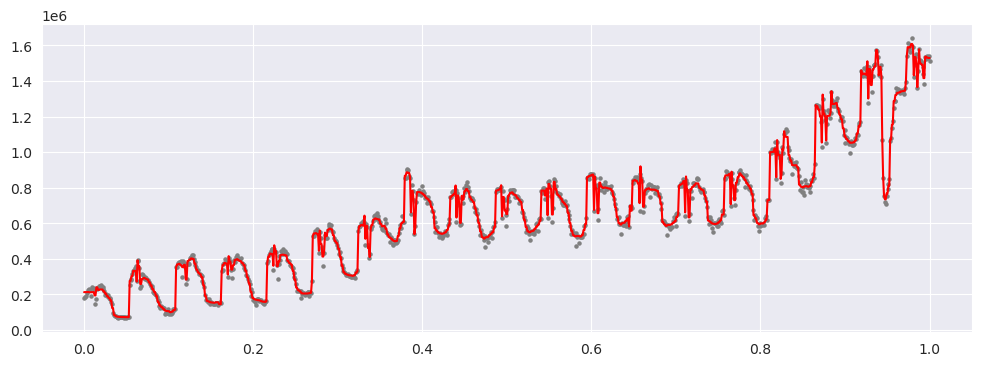

In [26]:
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
plt.plot(np.linspace(0,1,len(y)),wave.mu, color='red')
plt.show()

In [27]:
model = VEBTF(sigma2=1,printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/2,maxiter=1000)
model.fit(y,mu_init = genlasso.mu)  

Iteration 0: ELBO = -22381.578071239543


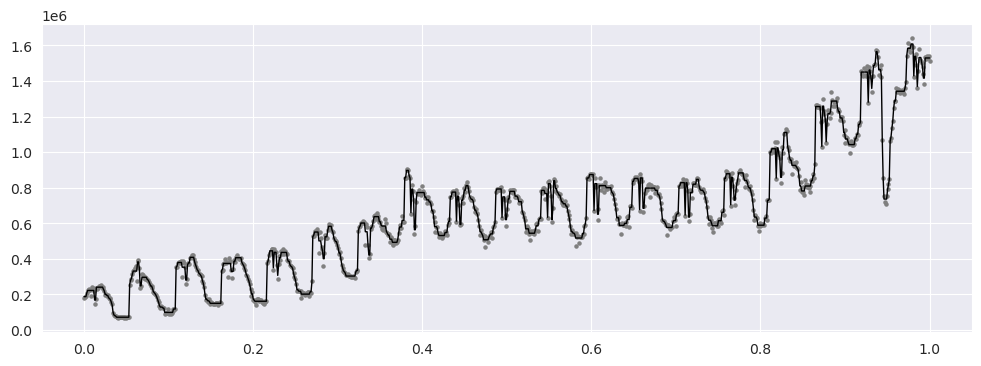

In [28]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
plt.plot(np.linspace(0,1,len(y)),model.mu, color='black',linewidth=1)
plt.show()

In [17]:
gp = GP_sklearn(kernel="Matern32")
gp.fit(y/1e5)
print(gp.fitted_model.kernel_)

0.906**2 * Matern(length_scale=16.1, nu=1.5) + WhiteKernel(noise_level=0.0126)


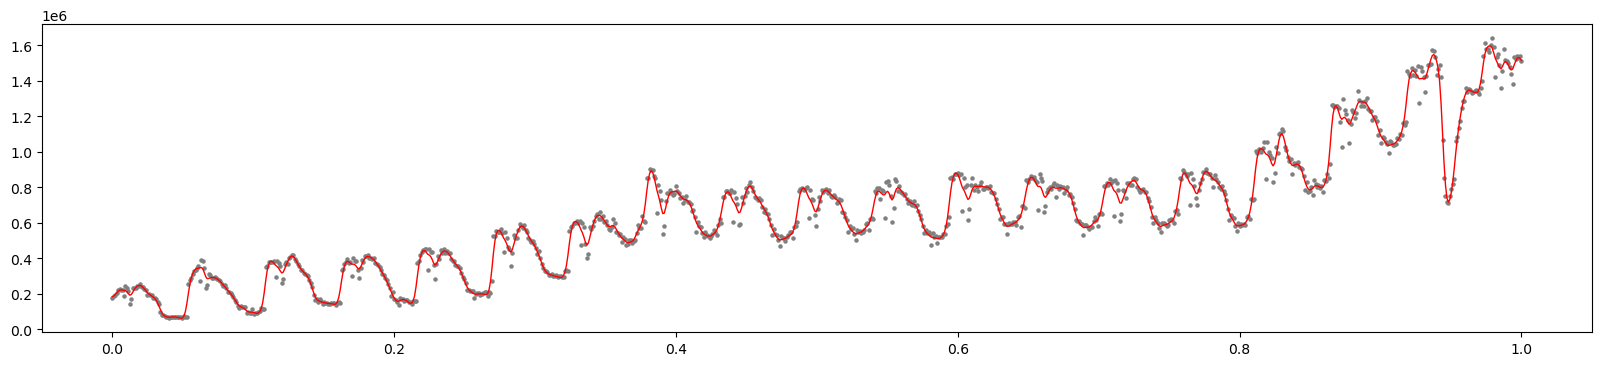

In [18]:
plt.figure(figsize=(20, 4))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
plt.plot(np.linspace(0,1,len(y)),gp.mu*1e5, color='red',linewidth=1)
plt.show()

In [ ]:
# df = df.rename(columns={'OT': 'target'})
# df.to_csv(os.path.expanduser("~/myPy/VEBTF/VEBTF-paper/realdata/dataset/benchmark/illness.csv"), index=False)

In [ ]:
# # save gp to a pickle file
# import pickle
# with open('results/gp_rbf_etth1.pkl', 'wb') as f:
#     pickle.dump(gp, f)

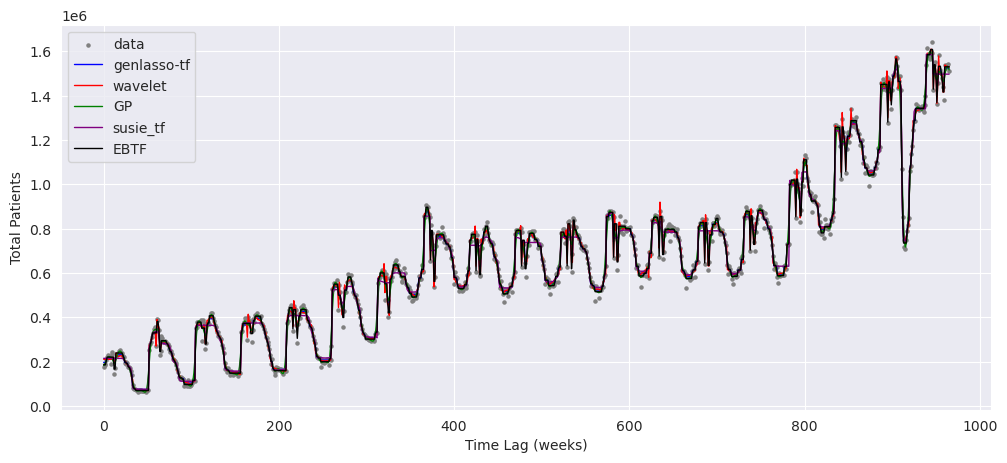

In [40]:
plt.figure(figsize=(12, 5))
idx = np.arange(0,n)
plot_n = len(idx)
plt.scatter(idx,y[idx],color='grey',s=5)

plt.plot(idx,genlasso.mu[idx], color='blue',linewidth = 1)
plt.plot(idx,wave.mu[idx], color='red',linewidth = 1)
plt.plot(idx,gp.mu[idx]*1e5, color='green',linewidth = 1)
plt.plot(idx,susie500.mu[idx], color='purple',linewidth = 1)
plt.plot(idx,model.mu[idx], color='black',linewidth = 1)


plt.legend(['data', 'genlasso-tf', 'wavelet', 'GP', 'susie_tf', 'EBTF'], 
           loc='upper left', fontsize=10, frameon=True)

# plt.legend(['data', 'genLasso-tf', 'wavelet', 'GP', 'susie_tf','EBTF'],loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=6)
plt.xlabel("Time Lag (weeks)")
plt.ylabel("Total Patients")
plt.savefig('results/illness.pdf', bbox_inches='tight')
plt.show()

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Iteration 0: ELBO = -3106.8252680542096


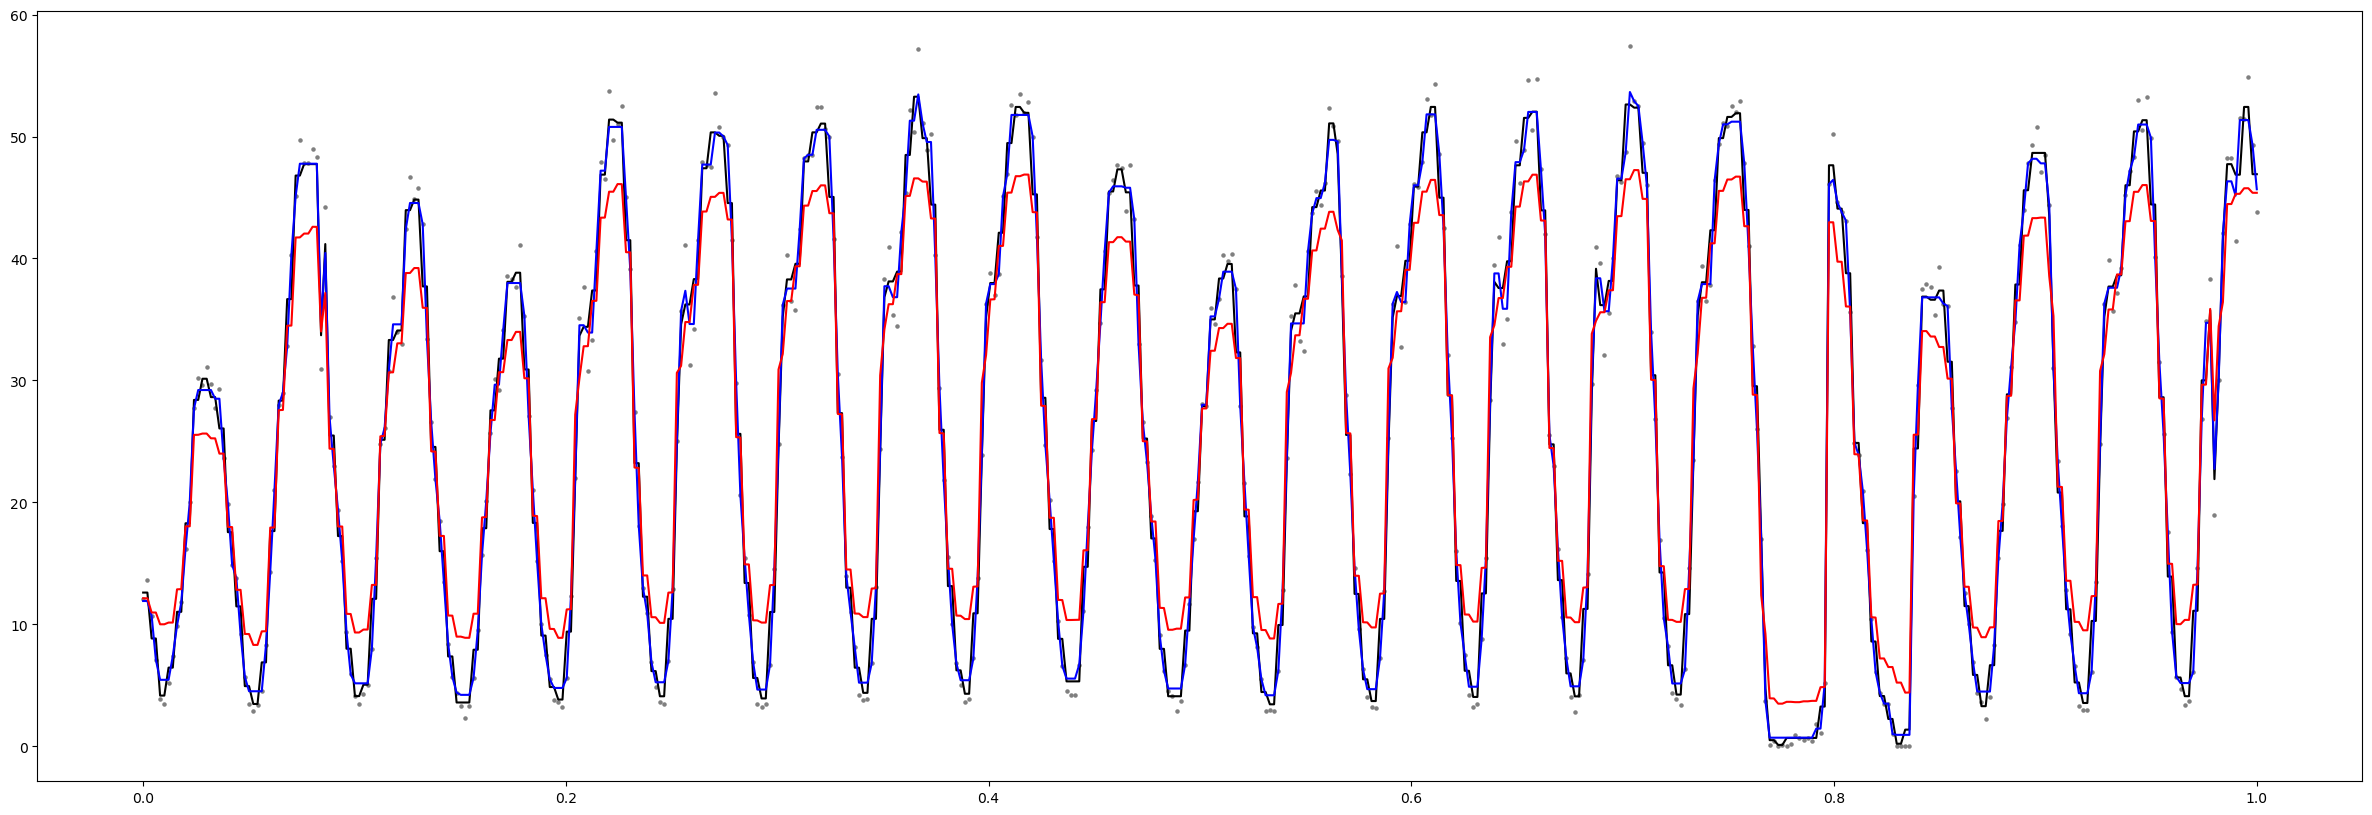

In [140]:
y = y[0:500]
n = len(y)
y = np.array(y,dtype=float)*1000
genlasso = genlasso_tf(ord=0,k=5)
genlasso.fit(y)
model = VEBTF(sigma2=1,printevery=100,prior="ash_update",tol=1e-5,point_mass_sd=np.sqrt(1/n)/2,maxiter=1000,num_shift_wavelet=n,method_wavelet='VisuShrink')
model.fit(y,mu_init = 'wavelet')    
wave = wavelet_denoise(wavelet='haar', num_shifts=n)
wave.fit(y)
plt.figure(figsize=(30, 10))
plt.scatter(np.linspace(0,1,len(y)),y,color='grey',s=5)
plt.plot(np.linspace(0,1,len(y)),model.mu, color='black')
plt.plot(np.linspace(0,1,len(y)),genlasso.mu, color='blue')
plt.plot(np.linspace(0,1,len(y)),wave.mu, color='red')
plt.show()

In [118]:
print(model.pi)
print(model.sk2)

[5.80771972e-01 1.27171858e-02 8.65715503e-03 5.63913342e-03
 3.57111704e-03 2.21921812e-03 1.36125652e-03 8.27355708e-04
 4.99528335e-04 3.00060196e-04 1.79409484e-04 1.06666952e-04
 6.28434804e-05 3.64276680e-05 2.05327107e-05 1.10554163e-05
 5.48714777e-06 2.21800767e-06 2.95627110e-07 3.19417380e-10
 4.52671432e-10 5.53218128e-10 6.21376244e-10 6.70796881e-10
 8.43948000e-10 1.29663252e-09 1.66604535e-09 1.85148565e-09
 1.87552348e-09 1.79904706e-09 1.67484294e-09 1.53336455e-09
 1.39517631e-09 1.27492699e-09 1.17620221e-09 1.09977918e-09
 1.04064501e-09 9.91943590e-10 9.52036681e-10 9.19504298e-10
 8.92812557e-10 8.74104536e-10 8.59234119e-10 8.46755492e-10
 8.34772716e-10 8.24096192e-10 8.12861849e-10 8.01479809e-10
 7.92761178e-10 7.92761178e-10 7.92761178e-10 7.92761178e-10
 7.92761178e-10 3.32938122e-09 2.06373967e-06 4.99534494e-05
 2.85410953e-04 8.34564749e-04 1.39126354e-03 1.58705467e-03
 1.55836973e-03 1.57234277e-03 1.88214213e-03 2.82440672e-03
 4.90410642e-03 7.880687

In [107]:
model.sigma2

3367557.0379062244